In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import *
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import *
import sklearn.metrics as skm

# A Classification Test of Sentiment of Tweets About Braziliam Presidential Elections

### Importing Data

In [2]:
data = pd.read_csv('../Data/dataset2018.tsv', header=0, delimiter='\t')

In [3]:
data.head(10)

,id,tweet,candidato,marcador,classe
0,twe977318071722442752,"@jangodurango ""Se eu soubesse que tu queria nã...",lula,alysson,Não sei
1,twe978104151359008769,Retweeted Florisvaldo Raimundo (@Florisrs): S...,lula,alysson,Não sei
2,twe984802485360582656,Ao invés dos petistas estarem buscando livrar ...,alckmin,alysson,Rejeição
3,twe977572021361168389,@CshmKnCaioHen @Peaotrabalhador @MiguelAMSA61 ...,manuela,alysson,Neutro
4,twe977558211447443457,"A pergunta é séria, @manudeputada: quer me pag...",manuela,alysson,Rejeição
5,twe977347407011897345,DISPARADO!!! 90%... https://t.co/f5G9063duC,bolsonaro,alysson,Neutro
6,twe984494027956543488,O que acontece agora que o inquérito de Alckmi...,alckmin,alysson,Neutro
7,twe981677295676084224,"- ""aécio é flagrado pedindo grana a empresário...",temer,alysson,Rejeição
8,twe978200570740822017,Se a bunda de algum ministro sentar sobre o pr...,lula,alysson,Rejeição
9,twe982682347484180482,"Hoje, não há lado certo ou lado errado. Lula é...",temer,alysson,Neutro


In [4]:
data = data[data['classe'] != 'Não sei']
data['classe'][data['classe'] == 'Rejeição'] = 2
data['classe'][data['classe'] == 'Neutro'] = 0
data['classe'][data['classe'] == 'Aprovação'] = 1
data = data.dropna()
data['classe'] = data['classe'].astype('int64')

In [5]:
candidate_name = 'bolsonaro'

### Counting the number of tweets for each candidate

In [6]:
def count_tweets_per_candidate(data):
    counteds = set()
    counter_map = {}
    for i in range(len(data['candidato'])):
        if data['candidato'].iloc[i] not in counteds:
            candidate_name = data['candidato'].iloc[i]
            counter_map[candidate_name] = len(data[data['candidato'] == candidate_name])
            counteds.add(candidate_name)
    return counter_map

In [7]:
counter_map = count_tweets_per_candidate(data)

In [8]:
counter_map

{'alckmin': 158,
 'bolsonaro': 137,
 'ciro': 130,
 'lula': 133,
 'manuela': 156,
 'marina': 163,
 'temer': 128}

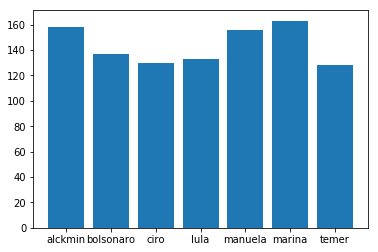

In [9]:
xLabels = list(counter_map.keys())
yValues = np.array(list(counter_map.values()))

fig, ax = plt.subplots()
plt.bar(xLabels, yValues)

plt.show()

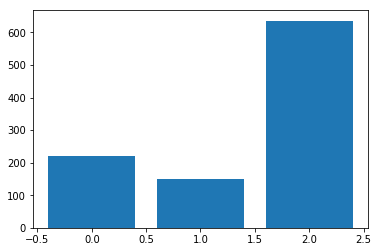

In [10]:
xLabels = list(data['classe'].value_counts().keys())
yValues = list(data['classe'].value_counts())
fig, ax = plt.subplots()
plt.bar(xLabels, yValues)
plt.show()

### Pre-processing tweets

In [11]:
def tweet2wordlist(tweet):
    tweet = BeautifulSoup(tweet, 'lxml').get_text()
    tweet = tweet.lower()
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    stops = set(nltk.corpus.stopwords.words('portuguese'))
    words = nltk.word_tokenize(tweet.lower().strip())
    stemmer = nltk.stem.RSLPStemmer()
    word_list = [stemmer.stem(word) for word in words if word not in stops]
    return ' '.join(word_list)
    

In [12]:
def pre_processing(data):
    word_lists = []
    for tweet in data['tweet']:
        word_list = tweet2wordlist(tweet)
        if word_list != []:
            word_lists.append(word_list)
    return word_lists

In [13]:
vectorizer = CountVectorizer(analyzer='word', preprocessor=None, stop_words=None)
tfidf = TfidfTransformer()
train_candidate = vectorizer.fit_transform(pre_processing(data)).toarray()
features_tfidf = tfidf.fit_transform(train_candidate).toarray()
#train_candidate = features_tfidf

/home/raul/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "https://t.co/xK5tGzIwWb" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [14]:
y_pred = cross_val_predict(MultinomialNB(), train_candidate, data['classe'], cv=2)
precision_recall_fscore_support(y_pred=y_pred, y_true=data['classe'])

(array([0.45789474, 0.20731707, 0.72442019]),
 array([0.39545455, 0.11409396, 0.83490566]),
 array([0.42439024, 0.14718615, 0.77574872]),
 array([220, 149, 636]))

In [15]:
y_pred = cross_val_predict(BernoulliNB(), train_candidate, data['classe'], cv=2)
precision_recall_fscore_support(y_pred=y_pred, y_true=data['classe'])

(array([0.63888889, 0.4       , 0.65041494]),
 array([0.10454545, 0.01342282, 0.98584906]),
 array([0.1796875 , 0.02597403, 0.78375   ]),
 array([220, 149, 636]))

In [16]:
y_pred = cross_val_predict(GaussianNB(), train_candidate, data['classe'], cv=2)
precision_recall_fscore_support(y_pred=y_pred, y_true=data['classe'])

(array([0.44117647, 0.23170732, 0.71631206]),
 array([0.27272727, 0.25503356, 0.79402516]),
 array([0.33707865, 0.2428115 , 0.75316928]),
 array([220, 149, 636]))

In [17]:
y_pred = cross_val_predict(RandomForestClassifier(), train_candidate, data['classe'], cv=2)
precision_recall_fscore_support(y_pred=y_pred, y_true=data['classe'])

(array([0.47008547, 0.44642857, 0.69951923]),
 array([0.25      , 0.16778523, 0.91509434]),
 array([0.3264095 , 0.24390244, 0.79291553]),
 array([220, 149, 636]))

In [18]:
y_pred = cross_val_predict(LinearSVC(), train_candidate, data['classe'], cv=2)
precision_recall_fscore_support(y_pred=y_pred, y_true=data['classe'])

(array([0.40609137, 0.30578512, 0.74090247]),
 array([0.36363636, 0.24832215, 0.80031447]),
 array([0.38369305, 0.27407407, 0.76946334]),
 array([220, 149, 636]))